In [171]:
import pandas as pd
import numpy as np 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [172]:
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

In [173]:
print(train_df.isnull().sum())

date                   0
org                 3451
tld                 3453
ccs                    0
bcced                  0
mail_type            172
images                 0
urls                   0
salutations            0
designation            0
chars_in_subject      16
chars_in_body          0
label                  0
dtype: int64


In [174]:
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# splits out the day with the date/time
new = train_df["date"].str.split(", ", n=1, expand=True) 

# only splits if the time starts with the day of the week. This covers 97% of the data.
conditions1  = [new[0].str.contains("Mon", na = False), new[0].str.contains("Tue", na = False), new[0].str.contains("Wed", na = False), new[0].str.contains("Thu", na = False), new[0].str.contains("Fri", na = False), new[0].str.contains("Sat", na = False), new[0].str.contains("Sun", na = False)]
choices1     = [ "Mon", 'Tues', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
new[0] = np.select(conditions1, choices1, default=np.nan)
train_df["day"] = new[0]

# blanks out the time for the ones that don't have day
conditions2  = [new[0] == 0]
choices2     = [0]
new[1] = np.select(conditions2, choices2, default = new[1])

# add time and date to the training data
day_month_year = new[1].str.split(" ", n=3, expand = True) # splits out the day, month, year, time
day_month_year["date"] = day_month_year[0]+day_month_year[1] # not very clean
time = day_month_year[3].str.split(" ", n=1, expand = True)
train_df["time"] = time[0]
train_df["date_new"] = day_month_year["date"]

# convert time to datetime
train_df["time"] = pd.to_datetime(train_df["time"]).dt.time
train_df["hour"] = train_df["time"].apply(lambda x:x.hour)
print(train_df.head(102))

                                      date          org           tld  ccs  \
0           Mon, 6 Nov 2017 11:13:45 +0100        reply       ebay.in    0   
1          Wed, 14 Feb 2018 11:00:16 -0000          edm  efinmail.com    0   
2           Wed, 6 Jul 2016 19:53:37 +0000  usebackpack           com    0   
3          Fri, 11 Oct 2019 11:25:40 +0200     granular            ai    0   
4    Tue, 07 Nov 2017 11:07:18 +0000 (UTC)       github           com    1   
..                                     ...          ...           ...  ...   
97         Wed, 31 May 2017 05:37:18 +0000    innerchef           com    0   
98         Wed, 09 Mar 2016 16:51:20 +0000      youtube           com    0   
99          Tue, 3 May 2016 17:08:35 +0530        iiitd         ac.in    0   
100             17 Jul 2018 22:05:04 +0530          NaN           NaN    0   
101        Wed, 15 Jan 2020 07:22:09 +0000       mailer   netflix.com    0   

     bcced              mail_type  images  urls  salutations  d

In [175]:
# do the same with test
# splits out the day with the date/time
newt = test_df["date"].str.split(", ", n=1, expand=True) 

# only splits if the time starts with the day of the week. This covers 97% of the data.
conditions4  = [newt[0].str.contains("Mon", na = False), newt[0].str.contains("Tue", na = False), newt[0].str.contains("Wed", na = False), newt[0].str.contains("Thu", na = False), newt[0].str.contains("Fri", na = False), newt[0].str.contains("Sat", na = False), newt[0].str.contains("Sun", na = False)]
choices4     = [ "Mon", 'Tues', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
newt[0] = np.select(conditions4, choices4, default=np.nan)
test_df["day"] = newt[0]

# blanks out the time for the ones that don't have day
conditions5  = [newt[0] == 0]
choices5     = [0]
newt[1] = np.select(conditions5, choices5, default = newt[1])

# add time and date to the training data
day_month_year2 = new[1].str.split(" ", n=3, expand = True) # splits out the day, month, year, time
day_month_year2["date"] = day_month_year2[0]+day_month_year2[1] # not very clean
time2 = day_month_year2[3].str.split(" ", n=1, expand = True)
test_df["time"] = time2[0]
test_df["date_new"] = day_month_year2["date"]

# convert time to datetime
test_df["time"] = pd.to_datetime(test_df["time"]).dt.time
test_df["hour"] = test_df["time"].apply(lambda x:x.hour)


In [176]:
print(train_df.isnull().sum())
#print(train_df.isna().sum())
print(test_df.isnull().sum())

date                   0
org                 3451
tld                 3453
ccs                    0
bcced                  0
mail_type            172
images                 0
urls                   0
salutations            0
designation            0
chars_in_subject      16
chars_in_body          0
label                  0
day                    0
time                2087
date_new            2087
hour                2087
dtype: int64
date                   0
org                 1536
tld                 1536
ccs                    0
bcced                  0
mail_type             80
images                 0
urls                   0
salutations            0
designation            0
chars_in_subject       6
chars_in_body          0
day                    0
time                 895
date_new             895
hour                 895
dtype: int64


In [177]:
imp = SimpleImputer(strategy='most_frequent', missing_values=np.NaN)
#Missing values in object fields replace my most frequent
train_df.mail_type= imp.fit_transform(train_df['mail_type'].values.reshape(-1,1))[:,0]
train_df.org= imp.fit_transform(train_df['org'].values.reshape(-1,1))[:,0]
train_df.tld= imp.fit_transform(train_df['tld'].values.reshape(-1,1))[:,0]
#RG Check with Sakshi
train_df.hour= imp.fit_transform(train_df['hour'].values.reshape(-1,1))[:,0]


train_df['chars_in_subject'].fillna(train_df['chars_in_subject'].median(), inplace=True)
#train_df['chars_in_body'].fillna(train_df['chars_in_body'].median(), inplace=True)

# Reapeating for test data frame

#Missing values in object fields replace my most frequent
test_df.mail_type= imp.fit_transform(test_df['mail_type'].values.reshape(-1,1))[:,0]
test_df.org= imp.fit_transform(test_df['org'].values.reshape(-1,1))[:,0]
test_df.tld= imp.fit_transform(test_df['tld'].values.reshape(-1,1))[:,0]
test_df.hour= imp.fit_transform(test_df['hour'].values.reshape(-1,1))[:,0]


test_df['chars_in_subject'].fillna(test_df['chars_in_subject'].median(), inplace=True)
test_df['chars_in_body'].fillna(test_df['chars_in_body'].median(), inplace=True)

print(train_df.isnull().sum())
print(test_df.isnull().sum())

date                   0
org                    0
tld                    0
ccs                    0
bcced                  0
mail_type              0
images                 0
urls                   0
salutations            0
designation            0
chars_in_subject       0
chars_in_body          0
label                  0
day                    0
time                2087
date_new            2087
hour                   0
dtype: int64
date                  0
org                   0
tld                   0
ccs                   0
bcced                 0
mail_type             0
images                0
urls                  0
salutations           0
designation           0
chars_in_subject      0
chars_in_body         0
day                   0
time                895
date_new            895
hour                  0
dtype: int64


In [178]:
temp = train_df['mail_type'].str.lower().str.strip().str.split('/', expand=True)
temp.rename(columns = {0:'mail_type_1', 1:'mail_type_2'}, inplace = True)

train_df = pd.concat([train_df, temp], axis=1)
train_df.drop('mail_type', axis=1, inplace=True)

In [179]:
temp2 = test_df['mail_type'].str.lower().str.strip().str.split('/', expand=True)
temp2.rename(columns = {0:'mail_type_1', 1:'mail_type_2'}, inplace = True)

test_df = pd.concat([test_df, temp2], axis=1)
test_df.drop('mail_type', axis=1, inplace=True)


In [180]:
train_df = train_df.replace(np.nan, 0)
test_df = test_df.replace(np.nan, 0)
print(train_df.isnull().sum())
print(test_df.isnull().sum())


date                0
org                 0
tld                 0
ccs                 0
bcced               0
images              0
urls                0
salutations         0
designation         0
chars_in_subject    0
chars_in_body       0
label               0
day                 0
time                0
date_new            0
hour                0
mail_type_1         0
mail_type_2         0
dtype: int64
date                0
org                 0
tld                 0
ccs                 0
bcced               0
images              0
urls                0
salutations         0
designation         0
chars_in_subject    0
chars_in_body       0
day                 0
time                0
date_new            0
hour                0
mail_type_1         0
mail_type_2         0
dtype: int64


In [181]:
train_df['period'] = pd.cut(x=train_df['hour'], bins=[-1, 6,12, 18, 24], labels = ['1', '2', '3', '4'])
test_df['period'] = pd.cut(x=test_df['hour'], bins=[-1, 6, 12, 18, 24], labels = ['1', '2', '3', '4'])


In [182]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

date                0
org                 0
tld                 0
ccs                 0
bcced               0
images              0
urls                0
salutations         0
designation         0
chars_in_subject    0
chars_in_body       0
label               0
day                 0
time                0
date_new            0
hour                0
mail_type_1         0
mail_type_2         0
period              0
dtype: int64
date                0
org                 0
tld                 0
ccs                 0
bcced               0
images              0
urls                0
salutations         0
designation         0
chars_in_subject    0
chars_in_body       0
day                 0
time                0
date_new            0
hour                0
mail_type_1         0
mail_type_2         0
period              0
dtype: int64


In [183]:
def one_hot_top(df,variable,top_X_labels):
  for label in top_X_labels:
    df[label] = np.where(df[variable]==label,1,0)
  df[[variable] + top_X_labels]

In [184]:
feature_org = [x for x in train_df.org.value_counts().sort_values(ascending=False).index]
one_hot_top(train_df,'org',feature_org)
#one_hot_top(test_data,'org',feature_org)
train_df.head()


/var/folders/1z/6xv37b5x00sf7h_1r86tk4lh0000gn/T/ipykernel_896/3002830861.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = np.where(df[variable]==label,1,0)
/var/folders/1z/6xv37b5x00sf7h_1r86tk4lh0000gn/T/ipykernel_896/3002830861.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = np.where(df[variable]==label,1,0)
/var/folders/1z/6xv37b5x00sf7h_1r86tk4lh0000gn/T/ipykernel_896/3002830861.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

,date,org,tld,ccs,bcced,images,urls,salutations,designation,chars_in_subject,...,preferred,teabox,synthia-dataset,cdconnect,hknu,pitchme,60,recruitment,dvc,freedns
0,"Mon, 6 Nov 2017 11:13:45 +0100",reply,ebay.in,0,0,35,120,0,0,49.0,...,0,0,0,0,0,0,0,0,0,0
1,"Wed, 14 Feb 2018 11:00:16 -0000",edm,efinmail.com,0,0,1,7,0,0,107.0,...,0,0,0,0,0,0,0,0,0,0
2,"Wed, 6 Jul 2016 19:53:37 +0000",usebackpack,com,0,0,4,17,0,0,35.0,...,0,0,0,0,0,0,0,0,0,0
3,"Fri, 11 Oct 2019 11:25:40 +0200",granular,ai,0,0,0,0,0,0,15.0,...,0,0,0,0,0,0,0,0,0,0
4,"Tue, 07 Nov 2017 11:07:18 +0000 (UTC)",github,com,1,0,2,11,0,0,49.0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
one_hot_top(test_df,'org',feature_org)

/var/folders/1z/6xv37b5x00sf7h_1r86tk4lh0000gn/T/ipykernel_896/3002830861.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = np.where(df[variable]==label,1,0)
/var/folders/1z/6xv37b5x00sf7h_1r86tk4lh0000gn/T/ipykernel_896/3002830861.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = np.where(df[variable]==label,1,0)
/var/folders/1z/6xv37b5x00sf7h_1r86tk4lh0000gn/T/ipykernel_896/3002830861.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [186]:
feature_tld = [x for x in train_df.tld.value_counts().sort_values(ascending=False).index]
one_hot_top(train_df,'tld',feature_tld)
one_hot_top(test_df,'tld',feature_tld)
#train_df.drop('tld',axis=1)
##train_data.drop(0,axis=1)
#test_df.drop('tld',axis=1)
##test_data.drop(0,axis=1)

/var/folders/1z/6xv37b5x00sf7h_1r86tk4lh0000gn/T/ipykernel_896/3002830861.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = np.where(df[variable]==label,1,0)
/var/folders/1z/6xv37b5x00sf7h_1r86tk4lh0000gn/T/ipykernel_896/3002830861.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = np.where(df[variable]==label,1,0)
/var/folders/1z/6xv37b5x00sf7h_1r86tk4lh0000gn/T/ipykernel_896/3002830861.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [187]:
train_df.head()

,date,org,tld,ccs,bcced,images,urls,salutations,designation,chars_in_subject,...,hosting,sap.stampmail.in,com.ar,chtah.com,ac.kr,xerox.com,flickr.com,mail-avis-verifies.com,cisco.com,ws
0,"Mon, 6 Nov 2017 11:13:45 +0100",0,ebay.in,0,0,35,120,0,0,49.0,...,0,0,0,0,0,0,0,0,0,0
1,"Wed, 14 Feb 2018 11:00:16 -0000",0,efinmail.com,0,0,1,7,0,0,107.0,...,0,0,0,0,0,0,0,0,0,0
2,"Wed, 6 Jul 2016 19:53:37 +0000",0,com,0,0,4,17,0,0,35.0,...,0,0,0,0,0,0,0,0,0,0
3,"Fri, 11 Oct 2019 11:25:40 +0200",0,ai,0,0,0,0,0,0,15.0,...,0,0,0,0,0,0,0,0,0,0
4,"Tue, 07 Nov 2017 11:07:18 +0000 (UTC)",0,com,1,0,2,11,0,0,49.0,...,0,0,0,0,0,0,0,0,0,0


In [188]:
train_df.drop('org', axis=1, inplace=True)
train_df.drop('tld', axis=1, inplace=True)


test_df.drop('org', axis=1, inplace=True)
test_df.drop('tld', axis=1, inplace=True)

In [189]:
print(train_df.head())
print(test_df.head())

                                    date  ccs  bcced  images  urls  \
0         Mon, 6 Nov 2017 11:13:45 +0100    0      0      35   120   
1        Wed, 14 Feb 2018 11:00:16 -0000    0      0       1     7   
2         Wed, 6 Jul 2016 19:53:37 +0000    0      0       4    17   
3        Fri, 11 Oct 2019 11:25:40 +0200    0      0       0     0   
4  Tue, 07 Nov 2017 11:07:18 +0000 (UTC)    1      0       2    11   

   salutations  designation  chars_in_subject  chars_in_body  label  ...  \
0            0            0              49.0          80027      2  ...   
1            0            0             107.0           2961      1  ...   
2            0            0              35.0          25149      1  ...   
3            0            0              15.0         635296      1  ...   
4            0            0              49.0           2355      1  ...   

  hosting sap.stampmail.in com.ar  chtah.com ac.kr xerox.com flickr.com  \
0       0                0      0          0   

In [190]:
list(train_df.columns)

['date',
 'ccs',
 'bcced',
 'images',
 'urls',
 'salutations',
 'designation',
 'chars_in_subject',
 'chars_in_body',
 'label',
 'day',
 'time',
 'date_new',
 'hour',
 'mail_type_1',
 'mail_type_2',
 'period',
 'iiitd',
 'usebackpack',
 'google',
 'amazon',
 'linkedin',
 'twitter',
 'quora',
 'gmail',
 'github',
 'youtube',
 'nrsc',
 'centralesupelec',
 'topcoder',
 'coursera',
 'phpclasses',
 'medium',
 'mailer',
 'flipkartletters',
 'granular',
 'udacity',
 'nvidia',
 'standupalice',
 'mail',
 'sampark',
 'e',
 'hackerearth',
 'reply',
 'email',
 'ieee',
 'duolingo',
 'sbi',
 'kaggle',
 'news',
 'mentor',
 'olacabs',
 'newsletter',
 'slack',
 'hackerrank',
 'send',
 'accounts',
 'hackerrankmail',
 'm',
 'angel',
 'freshersworld',
 'piazza',
 'notifications',
 'redwolf',
 'academia-mail',
 'thomascook',
 'indiatimes',
 'crm',
 'statebankrewardz',
 'aamaadmiparty',
 'signalprocessingsociety',
 'glassdoor',
 'facebookmail',
 'state',
 'edx',
 'repositoryhosting',
 'usief',
 'researchgat

In [191]:
X = train_df.iloc[:,17:]
y = train_df['label']
print(X.head())

   iiitd  usebackpack  google  amazon  linkedin  twitter  quora  gmail  \
0      0            0       0       0         0        0      0      0   
1      0            0       0       0         0        0      0      0   
2      0            1       0       0         0        0      0      0   
3      0            0       0       0         0        0      0      0   
4      0            0       0       0         0        0      0      0   

   github  youtube  ...  hosting  sap.stampmail.in  com.ar  chtah.com  ac.kr  \
0       0        0  ...        0                 0       0          0      0   
1       0        0  ...        0                 0       0          0      0   
2       0        0  ...        0                 0       0          0      0   
3       0        0  ...        0                 0       0          0      0   
4       1        0  ...        0                 0       0          0      0   

   xerox.com  flickr.com  mail-avis-verifies.com  cisco.com  ws  
0       

In [192]:
train_df.head()

,date,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,...,hosting,sap.stampmail.in,com.ar,chtah.com,ac.kr,xerox.com,flickr.com,mail-avis-verifies.com,cisco.com,ws
0,"Mon, 6 Nov 2017 11:13:45 +0100",0,0,35,120,0,0,49.0,80027,2,...,0,0,0,0,0,0,0,0,0,0
1,"Wed, 14 Feb 2018 11:00:16 -0000",0,0,1,7,0,0,107.0,2961,1,...,0,0,0,0,0,0,0,0,0,0
2,"Wed, 6 Jul 2016 19:53:37 +0000",0,0,4,17,0,0,35.0,25149,1,...,0,0,0,0,0,0,0,0,0,0
3,"Fri, 11 Oct 2019 11:25:40 +0200",0,0,0,0,0,0,15.0,635296,1,...,0,0,0,0,0,0,0,0,0,0
4,"Tue, 07 Nov 2017 11:07:18 +0000 (UTC)",1,0,2,11,0,0,49.0,2355,1,...,0,0,0,0,0,0,0,0,0,0


In [193]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(penalty='l2', C=0.01)
model_lr.fit(X, y)
model_lr.coef_

model_sfm = SelectFromModel(model_lr, prefit=True)
model_sfm.transform(X).shape

/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(80176, 261)

In [194]:
#Xselect is the column indices used by the Logistic Regression

Xselect = model_sfm.get_support(indices=True)
print(Xselect.shape)

(261,)


In [195]:
# trdata is taking the location of Xselect columns and crating a new dataset for testing
# # these are the main columns used by the LR model. 
# This code creates a reduced set for the training and testing data
trdata = X.iloc[:,Xselect]
tsdata = test_df[trdata.columns]

In [196]:
#RG
trdata.shape

(80176, 261)

In [197]:
print(trdata)


       iiitd  usebackpack  google  amazon  linkedin  twitter  quora  gmail  \
0          0            0       0       0         0        0      0      0   
1          0            0       0       0         0        0      0      0   
2          0            1       0       0         0        0      0      0   
3          0            0       0       0         0        0      0      0   
4          0            0       0       0         0        0      0      0   
...      ...          ...     ...     ...       ...      ...    ...    ...   
80171      0            0       0       0         0        0      0      0   
80172      1            0       0       0         0        0      0      0   
80173      0            0       1       0         0        0      0      0   
80174      0            0       0       0         0        0      0      0   
80175      1            0       0       0         0        0      0      0   

       github  youtube  ...  icims.com  schneider-electric.com 

In [198]:
print(tsdata)

       iiitd  usebackpack  google  amazon  linkedin  twitter  quora  gmail  \
0          1            0       0       0         0        0      0      0   
1          0            0       0       0         0        0      0      0   
2          1            0       0       0         0        0      0      0   
3          0            0       0       0         0        0      0      0   
4          0            0       1       0         0        0      0      0   
...      ...          ...     ...     ...       ...      ...    ...    ...   
34360      0            0       0       0         0        0      1      0   
34361      0            0       0       0         0        0      0      0   
34362      1            0       0       0         0        0      0      0   
34363      0            0       0       0         0        0      0      0   
34364      0            0       0       0         0        0      0      0   

       github  youtube  ...  icims.com  schneider-electric.com 

In [199]:
train_df=pd.concat([train_df.iloc[:,0:17],trdata],axis=1)
test_df=pd.concat([test_df.iloc[:,0:16],tsdata],axis=1)

In [200]:
print(train_df)
print(test_df)

                                        date  ccs  bcced  images  urls  \
0             Mon, 6 Nov 2017 11:13:45 +0100    0      0      35   120   
1            Wed, 14 Feb 2018 11:00:16 -0000    0      0       1     7   
2             Wed, 6 Jul 2016 19:53:37 +0000    0      0       4    17   
3            Fri, 11 Oct 2019 11:25:40 +0200    0      0       0     0   
4      Tue, 07 Nov 2017 11:07:18 +0000 (UTC)    1      0       2    11   
...                                      ...  ...    ...     ...   ...   
80171        Tue, 30 Jun 2020 05:55:20 -0700    1      0       0     8   
80172  Fri,  1 May 2015 11:48:55 +0530 (IST)    0      0       0     2   
80173        Tue, 26 May 2020 08:18:43 -0700    0      0      27    85   
80174  Fri, 14 Dec 2018 09:01:13 +0000 (UTC)    0      0      32   239   
80175        Sun, 21 Oct 2012 23:43:49 -0400    0      0       0     5   

       salutations  designation  chars_in_subject  chars_in_body  label  ...  \
0                0            0

In [201]:
feature_mail_type_1 = [x for x in train_df.mail_type_1.value_counts().sort_values(ascending=False).index]
one_hot_top(train_df,'mail_type_1',feature_mail_type_1)
one_hot_top(test_df,'mail_type_1',feature_mail_type_1)
train_df.drop('mail_type_1',axis=1, inplace=True)
test_df.drop('mail_type_1',axis=1, inplace=True)
##train_data.drop(0,axis=1)
#test_data.drop('mail_type',axis=1)
##test_data.drop(0,axis=1)

In [202]:
print(train_df.head())
print(test_df.head())

                                    date  ccs  bcced  images  urls  \
0         Mon, 6 Nov 2017 11:13:45 +0100    0      0      35   120   
1        Wed, 14 Feb 2018 11:00:16 -0000    0      0       1     7   
2         Wed, 6 Jul 2016 19:53:37 +0000    0      0       4    17   
3        Fri, 11 Oct 2019 11:25:40 +0200    0      0       0     0   
4  Tue, 07 Nov 2017 11:07:18 +0000 (UTC)    1      0       2    11   

   salutations  designation  chars_in_subject  chars_in_body  label  ...  \
0            0            0              49.0          80027      2  ...   
1            0            0             107.0           2961      1  ...   
2            0            0              35.0          25149      1  ...   
3            0            0              15.0         635296      1  ...   
4            0            0              49.0           2355      1  ...   

  notion.so sinkback.com progressingindia.com  laposte.info universalnewz.com  \
0         0            0                 

In [203]:
feature_mail_type_2 = [x for x in train_df.mail_type_2.value_counts().sort_values(ascending=False).index]
one_hot_top(train_df,'mail_type_2',feature_mail_type_2)
one_hot_top(test_df,'mail_type_2',feature_mail_type_2)
train_df.drop('mail_type_2',axis=1, inplace=True)
##train_data.drop(0,axis=1)
test_df.drop('mail_type_2',axis=1,inplace=True)
##test_data.drop(0,axis=1)

In [204]:
print(train_df.head())
print(test_df.head())

                                    date  ccs  bcced  images  urls  \
0         Mon, 6 Nov 2017 11:13:45 +0100    0      0      35   120   
1        Wed, 14 Feb 2018 11:00:16 -0000    0      0       1     7   
2         Wed, 6 Jul 2016 19:53:37 +0000    0      0       4    17   
3        Fri, 11 Oct 2019 11:25:40 +0200    0      0       0     0   
4  Tue, 07 Nov 2017 11:07:18 +0000 (UTC)    1      0       2    11   

   salutations  designation  chars_in_subject  chars_in_body  label  ... text  \
0            0            0              49.0          80027      2  ...    0   
1            0            0             107.0           2961      1  ...    0   
2            0            0              35.0          25149      1  ...    1   
3            0            0              15.0         635296      1  ...    0   
4            0            0              49.0           2355      1  ...    0   

  alternative html  mixed plain  related  signed  report  calendar  idm  
0           1    0

In [205]:
feature_day = [x for x in train_df.day.value_counts().sort_values(ascending=False).index]
one_hot_top(train_df,'day',feature_day)
one_hot_top(test_df,'day',feature_day)
train_df.drop('day',axis=1, inplace=True)
##train_data.drop(0,axis=1)
test_df.drop('day',axis=1, inplace=True)
##test_data.drop(0,axis=1)

In [206]:
train_df = train_df.drop(columns=["date","time","date_new","hour","nan"],axis=1)
test_df = test_df.drop(columns=["date","time","date_new","hour","nan"],axis=1)

In [207]:
train_df

,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,period,...,report,calendar,idm,Tues,Fri,Thu,Mon,Wed,Sat,Sun
0,0,0,35,120,0,0,49.0,80027,2,2,...,0,0,0,0,0,0,1,0,0,0
1,0,0,1,7,0,0,107.0,2961,1,2,...,0,0,0,0,0,0,0,1,0,0
2,0,0,4,17,0,0,35.0,25149,1,4,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,15.0,635296,1,2,...,0,0,0,0,1,0,0,0,0,0
4,1,0,2,11,0,0,49.0,2355,1,2,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80171,1,0,0,8,0,0,91.0,1307,3,1,...,0,0,0,1,0,0,0,0,0,0
80172,0,0,0,2,1,0,73.0,13464,0,1,...,0,0,0,0,1,0,0,0,0,0
80173,0,0,27,85,0,0,46.0,28485,0,2,...,0,0,0,1,0,0,0,0,0,0
80174,0,0,32,239,1,1,169.0,105276,0,2,...,0,0,0,0,1,0,0,0,0,0


In [208]:
train_df["url_image"] = train_df["images"]*train_df["urls"]

train_df['url_image'].values[train_df['url_image'].values > 0] = 1

In [209]:
test_df["url_image"] = test_df["images"]*test_df["urls"]

test_df['url_image'].values[test_df['url_image'].values > 0] = 1


In [210]:
train_df = train_df.drop(columns=["images","urls"],axis=1)
test_df = test_df.drop(columns=["images","urls"],axis=1)

In [211]:
train_y = train_df[['label']]

In [212]:
train_df.drop('label',axis=1,inplace=True)

In [213]:
new_train_1 = train_df
print(new_train_1.head())

   ccs  bcced  salutations  designation  chars_in_subject  chars_in_body  \
0    0      0            0            0              49.0          80027   
1    0      0            0            0             107.0           2961   
2    0      0            0            0              35.0          25149   
3    0      0            0            0              15.0         635296   
4    1      0            0            0              49.0           2355   

  period  iiitd  usebackpack  google  ...  calendar  idm  Tues  Fri  Thu  Mon  \
0      2      0            0       0  ...         0    0     0    0    0    1   
1      2      0            0       0  ...         0    0     0    0    0    0   
2      4      0            1       0  ...         0    0     0    0    0    0   
3      2      0            0       0  ...         0    0     0    1    0    0   
4      2      0            0       0  ...         0    0     1    0    0    0   

   Wed  Sat  Sun  url_image  
0    0    0    0          

In [214]:
print(new_train_1['period'])

0        2
1        2
2        4
3        2
4        2
        ..
80171    1
80172    1
80173    2
80174    2
80175    4
Name: period, Length: 80176, dtype: category
Categories (4, object): ['1' < '2' < '3' < '4']


In [215]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
new_train = pd.DataFrame(scalar.fit_transform(new_train_1))
new_test = pd.DataFrame(scalar.transform(test_df))

In [216]:
#RG
from sklearn.model_selection import train_test_split
#Split the Train data into Train and validate sets 
X_train, X_val, y_train, y_val = train_test_split(new_train, train_y, test_size=0.1, random_state=42)

In [217]:
#RG Print 

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(72158, 287)
(8018, 287)
(72158, 1)
(8018, 1)


In [218]:
#Classifying using only random forest - feel free to remove



from sklearn.ensemble import RandomForestClassifier

pf = RandomForestClassifier(n_estimators = 10, max_features = "sqrt" )
#RG Added
#pf.fit(new_train, train_y)
#pred_y = pf.predict(new_train)

pf.fit(X_train, y_train)
pred_y = pf.predict(X_val)

print("pred_y count: ", pred_y.shape)
print("new_train count: ", new_train.shape)

y_predtest_RFC = pf.predict(new_test)

## Save results to submission file
y_pred_RFC_test_df = pd.DataFrame(y_predtest_RFC, columns=['label'])
y_pred_RFC_test_df.to_csv('RFC_classifier.csv', index=True, index_label='Id')

#Classifying using only random forest - feel free to remove
#accuracy_score(train_y, pred_y)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_val,  pred_y.round(), normalize=True, sample_weight=None)
accuracy1 = accuracy_score(y_val,  pred_y.round(), normalize=False, sample_weight=None)
print('RFC',' Accuracy: %.2f' % (accuracy*100), accuracy1)
print(classification_report(y_val, pred_y.round()))

/var/folders/1z/6xv37b5x00sf7h_1r86tk4lh0000gn/T/ipykernel_896/1895644592.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  pf.fit(X_train, y_train)


pred_y count:  (8018,)
new_train count:  (80176, 287)
RFC  Accuracy: 42.03 3370
              precision    recall  f1-score   support

           0       0.45      0.42      0.44      1873
           1       0.40      0.42      0.41      3675
           2       0.34      0.32      0.33       847
           3       0.54      0.54      0.54      1070
           4       0.06      0.09      0.07        22
           5       0.07      0.11      0.08         9
           6       0.00      0.00      0.00        17
           7       0.40      0.37      0.39       505

    accuracy                           0.42      8018
   macro avg       0.28      0.29      0.28      8018
weighted avg       0.42      0.42      0.42      8018



<AxesSubplot:title={'center':'Random Forest Confusion Matrix'}>

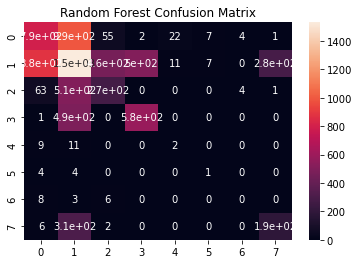

In [219]:
confusion = confusion_matrix(y_val, pred_y)
plt.title('Random Forest Confusion Matrix')
sns.heatmap(confusion,annot = True)

In [220]:
#RG  Classifying using SVC



from sklearn.svm import LinearSVC 

linSVC =  LinearSVC(C=0.01, penalty="l1", dual=False)


linSVC.fit(X_train, y_train)
pred_y = linSVC.predict(X_val)

y_predtest_SVC = linSVC.predict(new_test)

## Save results to submission file
y_pred_SVC_test_df = pd.DataFrame(y_predtest_SVC, columns=['label'])
y_pred_SVC_test_df.to_csv('SVC_classifier.csv', index=True, index_label='Id')

accuracy = accuracy_score(y_val,  pred_y.round(), normalize=True, sample_weight=None)
accuracy1 = accuracy_score(y_val,  pred_y.round(), normalize=False, sample_weight=None)
print('SVC',' Accuracy: %.2f' % (accuracy*100), accuracy1)
print(classification_report(y_val, pred_y.round()))

/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC  Accuracy: 56.45 4526
              precision    recall  f1-score   support

           0       0.62      0.49      0.54      1873
           1       0.55      0.69      0.61      3675
           2       0.53      0.44      0.48       847
           3       0.64      0.26      0.37      1070
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00         9
           6       0.40      0.12      0.18        17
           7       0.56      0.81      0.66       505

    accuracy                           0.56      8018
   macro avg       0.41      0.35      0.36      8018
weighted avg       0.57      0.56      0.55      8018



/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

<AxesSubplot:title={'center':'SVC Confusion Matrix'}>

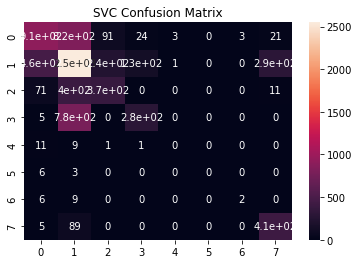

In [221]:
confusion = confusion_matrix(y_val, pred_y)
plt.title('SVC Confusion Matrix')
sns.heatmap(confusion,annot = True)

In [222]:
#RG  Classifying using KNN



from sklearn.neighbors import KNeighborsClassifier

KNN =  KNeighborsClassifier(n_neighbors=40,weights="uniform", leaf_size=2)

KNN.fit(X_train, y_train)
pred_y = KNN.predict(X_val)

y_predtest_KNN = KNN.predict(new_test)

## Save results to submission file
y_pred_KNN_test_df = pd.DataFrame(y_predtest_KNN, columns=['label'])
y_pred_KNN_test_df.to_csv('KNN_classifier.csv', index=True, index_label='Id')

accuracy = accuracy_score(y_val,  pred_y.round(), normalize=True, sample_weight=None)
accuracy1 = accuracy_score(y_val,  pred_y.round(), normalize=False, sample_weight=None)
print('KNN',' Accuracy: %.2f' % (accuracy*100), accuracy1)
print(classification_report(y_val, pred_y.round()))

/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN  Accuracy: 55.77 4472
              precision    recall  f1-score   support

           0       0.58      0.57      0.58      1873
           1       0.55      0.56      0.56      3675
           2       0.49      0.42      0.45       847
           3       0.60      0.56      0.58      1070
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00         9
           6       1.00      0.06      0.11        17
           7       0.56      0.74      0.64       505

    accuracy                           0.56      8018
   macro avg       0.47      0.36      0.36      8018
weighted avg       0.56      0.56      0.55      8018



/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

<AxesSubplot:title={'center':'KNN Confusion Matrix'}>

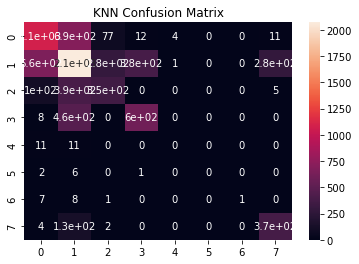

In [223]:
confusion = confusion_matrix(y_val, pred_y)
plt.title('KNN Confusion Matrix')
sns.heatmap(confusion,annot = True)

In [224]:
#RG  Classifying using Pipeline(Standard scaler, Logistic Regression)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data

pred_y  = pipe.predict(X_val)

y_predtest_LR= pipe.predict(new_test)

## Save results to submission file
y_pred_LR_test_df = pd.DataFrame(y_predtest_LR, columns=['label'])
y_pred_LR_test_df.to_csv('LR_classifier.csv', index=True, index_label='Id')

accuracy = accuracy_score(y_val,  pred_y.round(), normalize=True, sample_weight=None)
accuracy1 = accuracy_score(y_val,  pred_y.round(), normalize=False, sample_weight=None)
print('SSLR',' Accuracy: %.2f' % (accuracy*100), accuracy1)
print(classification_report(y_val, pred_y.round()))



/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SSLR  Accuracy: 56.64 4541
              precision    recall  f1-score   support

           0       0.60      0.52      0.56      1873
           1       0.56      0.64      0.60      3675
           2       0.52      0.45      0.48       847
           3       0.60      0.40      0.48      1070
           4       0.12      0.05      0.07        22
           5       0.00      0.00      0.00         9
           6       0.40      0.12      0.18        17
           7       0.56      0.78      0.65       505

    accuracy                           0.57      8018
   macro avg       0.42      0.37      0.38      8018
weighted avg       0.57      0.57      0.56      8018



<AxesSubplot:title={'center':'StdScaler Log Regression Confusion Matrix'}>

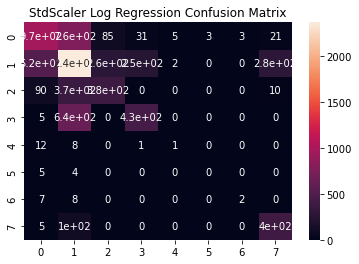

In [225]:
confusion = confusion_matrix(y_val, pred_y)
plt.title('StdScaler Log Regression Confusion Matrix')
sns.heatmap(confusion,annot = True)

In [169]:
#RG
pred_y = pf.predict(new_test)

In [123]:
pred_y.shape

(34365,)

In [124]:
#Classifying using only random forest - feel free to remove
pred_df = pd.DataFrame(pred_y, columns=['label'])
pred_df.to_csv("Final_output_RF.csv", index=True, index_label='Id')

In [125]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [126]:
#Classfying using gradient boosting

In [127]:
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
              ('lr', make_pipeline(StandardScaler(),LogisticRegression())),
              ('adaboost',AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2))),
              ('knn',make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=50)))]

final = make_pipeline(StandardScaler(),svm.SVC(kernel='linear', gamma=0.5, C=0.1,random_state=42))

classifier_final = StackingClassifier(estimators=estimators,final_estimator=final,cv=5)



In [128]:
#trying variations
estimators2 = [('rf', RandomForestClassifier(n_estimators=10, random_state=2)),
                ('svc',make_pipeline(StandardScaler(), svm.SVC(kernel='linear', gamma=0.5, C=0.1,random_state=2)) ),
                ('adaboost',AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2))),
                ('knn',make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=3)))]

#final = make_pipeline(StandardScaler(),svm.SVC(kernel='linear', gamma=0.5, C=0.1,random_state=42))

classifier_final_2 = StackingClassifier(estimators=estimators2,final_estimator=LogisticRegression(),cv=5)


In [129]:
#classifier_final_2.fit(new_train,train_y).score(new_train,train_y)
classifier_final.fit(new_train,train_y).score(new_train,train_y)

/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rhiannegonsalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

KeyboardInterrupt: 

In [ ]:
print(classifier_final)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('lr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('logisticregression',
                                                 LogisticRegression())])),
                               ('adaboost',
                                AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2))),
                               ('knn',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier(n_neig

In [ ]:
pred_y_2 = classifier_final.predict(new_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(new_train,train_y.round())

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

In [ ]:
pred_df_2 = pd.DataFrame(pred_y_2, columns=['label'])
pred_df_2.to_csv("Dec3_output.csv", index=True, index_label='Id')